In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import csv
import math
import matplotlib.pyplot as plt
# Device configuration
torch.cuda.set_device(0)
print(torch.cuda.is_available())

True


In [211]:
class StockPrediction:
    def __init__(self,filename):
        # read spcific company file
        file = open(filename)
        rows = csv.reader(file)
        next(rows) # remove header
        dataset = []
        for row in rows:
            dataset.append(row)
        self.dataset = np.array(dataset)
        file.close()
        # read Nasdaq index
        file = open('nasdaq.csv')
        rows = csv.reader(file)
        next(rows) # remove header
        nasdaq_data = []
        for row in rows:
            nasdaq_data.append(row)
        self.nasdaq_data = np.array(nasdaq_data)
        file.close()
        print("Data number:",len(dataset))
        #print("Data number2:",len(nasdaq_data))
    def getFeatures(self):
        single_day_features = self.dataset[:,1:]
        #single_day_features = np.append(single_day_features,self.nasdaq_data[:,5].reshape(len(self.nasdaq_data[:,5]),1),axis = 1)
        single_day_features =  single_day_features.astype(np.double)
        # Normalization
        for i in range(NUM_FEATURES):
            single_day_features[:,i] = (single_day_features[:,i] - np.min(single_day_features[:,i])) / (np.max(single_day_features[:,i])-np.min(single_day_features[:,i]))
        # get features
        self.features = []
        for i in range(len(self.dataset)-SEQ_LENGTH+1):
            self.features.append(single_day_features[i:i+SEQ_LENGTH].reshape(NUM_FEATURES*SEQ_LENGTH))
        
        self.features = np.array(self.features)
        self.predict_feature = self.features[-1,:]
        self.features = self.features[:-1,:]
    def getLabels(self):
        self.labels = self.dataset[SEQ_LENGTH:,5]
        self.labels = self.labels.astype(np.double)
        # normalization
        self.label_max = np.max(self.labels)
        self.label_min = np.min(self.labels)
        self.labels = (self.labels - np.min(self.labels))/(np.max(self.labels)-np.min(self.labels))
#     def getLabels(self):
#         adj_close = self.dataset[SEQ_LENGTH-1:,5]
#         adj_close = adj_close.astype(np.double)
#         self.labels = []
#         for i in range(1,len(adj_close)):
#             if((abs(adj_close[i]-adj_close[i-1])/adj_close[i-1]) > 0.015):
#                 if(adj_close[i] > adj_close[i-1]):
#                     self.labels.append(0)
#                 else:
#                     self.labels.append(2)
#             else:
#                 self.labels.append(1)
#         self.labels = np.array(self.labels)
#         self.labels = self.labels.astype(np.long)

    def shuffleData(self):
        data = np.append(self.features,self.labels.reshape(len(self.labels),1),axis=1)
        # np.random.shuffle(data[:-TEST_SIZE])
        np.random.shuffle(data[:])
        self.features = data[:,:NUM_FEATURES*SEQ_LENGTH]
        self.labels = data[:,NUM_FEATURES*SEQ_LENGTH]
    def splitTrainTest(self,test_size):
        self.train_features = self.features[:-test_size]
        self.test_features = self.features[-test_size:]
        self.train_labels = self.labels[:-test_size]
        self.test_labels = self.labels[-test_size:]
    def toTensor(self):
        self.train_features_ts = torch.from_numpy(self.train_features)
        self.test_features_ts = torch.from_numpy(self.test_features)
        self.train_labels_ts = torch.from_numpy(self.train_labels)
        self.test_labels_ts = torch.from_numpy(self.test_labels)
#         print(self.train_features_ts.shape)
#         print(self.train_labels_ts.shape)
    def train(self):
        self.model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS)
        self.model = self.model.cuda()
        
        # Loss and optimizer
        loss_func = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        
        # Prepare data loader
        train_dataset = torch.utils.data.TensorDataset(self.train_features_ts,self.train_labels_ts)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_dataset = torch.utils.data.TensorDataset(self.test_features_ts,self.test_labels_ts)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=TEST_SIZE, shuffle=False)
        
       
        self.train_loss_list = []
        self.test_loss_list = []
        train_loss = 0
        for ep in range(NUM_EPOCHS):
            # Train the model
            for i, (data, labels) in enumerate(train_loader):
                # resize
                data = Variable(data.view(-1, SEQ_LENGTH, INPUT_SIZE).float().cuda())
                labels = Variable(labels.view(len(labels),1).float().cuda())
                
                # forward pass
                outputs = self.model(data)
                train_loss = loss_func(outputs,labels)
                
                # backward and optimize
                optimizer.zero_grad() # clear gradient
                train_loss.backward() # backpropagation to get gradient
                optimizer.step() # optimize parameters
                
                # output result
                #print('Epoch:',ep+1,', Step:',i+1,', Loss:', train_loss.item())
                
            self.train_loss_list.append(train_loss.item())
            
            # Test the model
            test_loss = 0
            with torch.no_grad():
                for data , labels in test_loader:
                    # resize
                    data = data.view(-1, SEQ_LENGTH, INPUT_SIZE).float().cuda()
                    labels = labels.view(len(labels),1).float().cuda()

                    # forward pass
                    outputs = self.model(data)
                    test_loss = loss_func(outputs,labels)

                    # record loss
                    self.test_loss_list.append(test_loss.cpu().item())
    def test(self):
        # Prepare data loader
        test_dataset = torch.utils.data.TensorDataset(self.test_features_ts,self.test_labels_ts)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        
        # Test the model
        # In test phase, we don't need to compute gradients (for memory efficient)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for data , labels in test_loader:
                # resize
                data = data.view(-1, SEQ_LENGTH, INPUT_SIZE).cuda()
                labels = labels.float().cpu()
                # Forward pass
                outputs = self.model(data.float())
                
                # calculate reuslt
                n_samples += labels.size(0)
                labels = labels.item()
                if(abs(outputs.cpu().item()-labels)/(labels+0.00000001) < 0.015):
                    n_correct += 1
                print(outputs.cpu().item(),labels)
            accuracy = 100.0 * n_correct / n_samples
            print("Accuracy:",accuracy,"%", n_correct, n_samples)
    def predict(self):
        # get output
        with torch.no_grad():
            #print(self.predict_feature)
            data = torch.from_numpy(self.predict_feature).cuda()
            # resize
            data = data.view(-1, SEQ_LENGTH, INPUT_SIZE)
            
            # Forward pass
            output = self.model(data.float())
            _, predicted = torch.max(output.data, 1)
        print(predicted)
    def testResult(self):
        #
        with torch.no_grad():
            correct = 0
            for i in range(1,TEST_SIZE):
                data = self.test_features_ts[i]
                # resize
                data = data.view(-1, SEQ_LENGTH, INPUT_SIZE)

                # Forward pass
                output = self.model(data.float()).item()

                # restore output to normal value
                output = output*(self.label_max-self.label_min)+self.label_min
                now = self.test_labels[i]*(self.label_max-self.label_min)+self.label_min
                past = self.test_labels[i-1]*(self.label_max-self.label_min)+self.label_min
                r1 = -1
                r2 = -2
                if((abs(output-past)/past) > 0.015):
                    if(output > past):
                        print('0', end = ',')
                        r1 = 0
                    else:
                        print('2', end = ',')
                        r1 = 2
                else:
                    print('1', end = ',')
                    r1 = 1
                if((abs(now-past)/past) > 0.015):
                    if(now > past):
                        print('0')
                        r2 = 0
                    else:
                        print('2')
                        r2 = 2
                else:
                    print('1')
                    r2 = 1
                if(r2 == r1):
                    correct += 1
                # print(output, now , past,sep=',')
            print("Accuracy: ", correct/(TEST_SIZE-1))
    def plotGraph(self):
        plt.plot(self.train_loss_list,label="train")
        plt.plot(self.test_loss_list,label="test")  
        plt.title("Average Loss")
        plt.xlabel("Epochs")
        plt.ylabel("MSE Loss")
        plt.legend(loc='best')
        plt.show()
class LSTM(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS):
        super(LSTM, self).__init__()
        self.num_layers = NUM_LAYERS
        self.hidden_size = HIDDEN_SIZE
        self.lstm = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=NUM_LAYERS,
            batch_first = True, # use batch size as first dimension, x -> (batch_size, seq, input_size)
            dropout = DROP_OUT
        )
        self.fc = nn.Linear(HIDDEN_SIZE, 1) # fully connected

    def forward(self, x ):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        out, _ = self.lstm(x,(h0,c0))
        out = out[:,-1,:]
        out = self.fc(out)
        return out

Data number: 252
0.14148814976215363 0.131757915019989
0.9019135236740112 0.8354406952857971
0.08615931868553162 0.1293465793132782
0.6107049584388733 0.7502562999725342
0.7187737822532654 0.6619862914085388
0.6426511406898499 0.6599645018577576
0.21408584713935852 0.2114599347114563
0.1421288549900055 0.20450231432914734
0.5994511246681213 0.6178327202796936
0.1972978115081787 0.2454909235239029
0.2046661376953125 0.1787434071302414
-0.005211792886257172 0.0
0.6393910050392151 0.7392118573188782
0.23620450496673584 0.26839834451675415
0.8473033905029297 0.8770858645439148
0.5862877368927002 0.5774111151695251
0.6635407209396362 0.6594430208206177
0.402084082365036 0.3766380548477173
0.5613933205604553 0.5964858531951904
0.2741571366786957 0.23819181323051453
0.26292625069618225 0.2477671355009079
0.7320604920387268 0.7477025985717773
0.9544192552566528 0.8847681283950806
0.5816264152526855 0.518760085105896
0.45355725288391113 0.47094741463661194
0.5551043152809143 0.5992069244384766


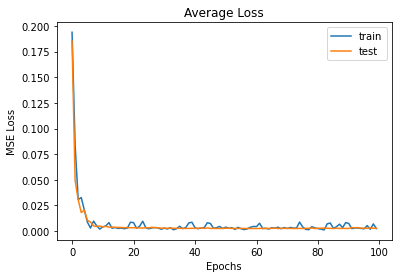

In [212]:
# Hyper-parameters
NUM_FEATURES = 6
TEST_SIZE = 50
NUM_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.01
DROP_OUT = 0.0

INPUT_SIZE = NUM_FEATURES # open, high, low, close, adj. close,volume
SEQ_LENGTH = 10
HIDDEN_SIZE = 128
NUM_LAYERS = 1
FILE_NAME = ['INTC.csv','AMD.csv','CSCO.csv','AAPL.csv','MU.csv','NVDA.csv','QCOM.csv','AMZN.csv','NFLX.csv','FB.csv'
             'GOOG.csv','BABA.csv','EBAY.csv','IBM.csv','XLNX.csv','TXN.csv','NOK.csv','TSLA.csv','MSFT.csv','SNPS.csv']

# Preprocess
for i in range(1):
    sp1 = StockPrediction(FILE_NAME[0])
    sp1.getFeatures()
    sp1.getLabels()
    sp1.shuffleData()
    sp1.splitTrainTest(TEST_SIZE)
    sp1.toTensor()
    sp1.train()
    sp1.test()
    sp1.plotGraph()
    #sp1.predict()